<a href="https://colab.research.google.com/github/adrian-valente/XAI_course_labs/blob/main/lab2_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/marcotcr/lime.git

  Cloning https://github.com/marcotcr/lime.git to /tmp/pip-req-build-rz8sw44r
  Running command git clone --filter=blob:none --quiet https://github.com/marcotcr/lime.git /tmp/pip-req-build-rz8sw44r
  Resolved https://github.com/marcotcr/lime.git to commit fd7eb2e6f760619c29fca0187c07b82157601b32
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=284256 sha256=73964a61098071d252ebdeb88f60f28629e3a8afa4073f089c4590910994a07c
  Stored in directory: /tmp/pip-ephem-wheel-cache-obymighx/wheels/02/5a/cf/76da8565581354b5e86552bdc470f3a01e26116c79925b1ed5
  Created wheel for pyDOE2: filename=pyDOE2-1.3.0-py3-none-any.whl size=25520 sha256=10b849abc695be79392ad10ab9d3ed85979f2cc09e2f0952f504501b88f69c87
  Stored in directory: /root/.cache/pip/wheels/46/1f/29/6fda5c72f950841e39147ae603780ee913a62f977b4ad47ee4
Successfully built lime pyDOE2


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import seaborn as sns

import sklearn
import sklearn.ensemble
from sklearn.metrics import f1_score
from sklearn.datasets import fetch_20newsgroups
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Lasso, LinearRegression

from lime.lime_text import LimeTextExplainer
from lime.lime_image import LimeImageExplainer

# Part 1: playing with LIME

In this first part we will get familiar with the LIME framework by interpreting predictions of a random forest trained to classify texts. We will use the standard 20 newsgroups dataset, which is a classification task of short e-mails into 20 categories, and will focus exclusively on two categories in the following.

In [ ]:
# Load dataset
categories = ['comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware']
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories)
class_names = newsgroups_train.target_names

In [ ]:
# Examine example data point
print(len(newsgroups_train.data))
print(newsgroups_train.target_names)
print(newsgroups_test.target_names)
print(newsgroups_train.data[0])
print(class_names[newsgroups_train.target[0]])

1168
['comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware']
['comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware']
From: randy@lynx.msc.cornell.edu.UUCP (Randall Jay Ellingson,199 Clark,55915,)
Subject: Re: IDE vs SCSI
Originator: randy@msc2.msc.cornell.edu
Organization: Cornell-Materials-Science-Center
Lines: 47

From article <1qq7i1INNdqc@dns1.NMSU.Edu>, by bgrubb@dante.nmsu.edu (GRUBB):
> wlsmith@valve.heart.rri.uwo.ca (Wayne Smith) write:
> 
>>In article <1qpu0uINNbt1@dns1.NMSU.Edu> bgrubb@dante.nmsu.edu (GRUBB) writes:
>>>wlsmith@valve.heart.rri.uwo.ca (Wayne Smith) writes:
>>>Since the Mac uses ONLY SCSI-1 for hard drives YES the "figure includes a
>>>hundred $$$ for SCSI drivers"  This is sloppy people and DUMB.
>>What group is this?  This is not a MAC group.
> Nice of you to DELETE BOTH YOUR responce and the item that prompted it.
> to whit:
>>>I just bought at Quantum 240 for my mac at home.  I paid $369 for it.  I
>                                       ^^^

[Tons of stuff dele

Let us first train a Random Forest on a [Tf-Idf vectorization](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) of the dataset.

In [ ]:
# Vectorization
vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(lowercase=False)
train_vectors = vectorizer.fit_transform(newsgroups_train.data)
test_vectors = vectorizer.transform(newsgroups_test.data)
print(train_vectors.shape)
print(test_vectors.shape)

# We will need this:
vocab = vectorizer.vocabulary_  # maps words -> integer
inverse_vocab = {vocab[w]: w for w in vocab}  # inverse mapping

(1168, 21486)
(777, 21486)


In [ ]:
# TODO train a random forest and evaluate it
rf = sklearn.ensemble.RandomForestClassifier(n_estimators=500)
rf.fit(train_vectors, newsgroups_train.target)

RandomForestClassifier(n_estimators=500)

In [ ]:
pred_train = rf.predict(train_vectors)
train_acc = (pred_train == newsgroups_train.target).mean()
train_f1 = f1_score(newsgroups_train.target, pred_train, average='binary')
print(f'Train performance: acc={train_acc:.3f}, f1={train_f1:.2f}')
pred = rf.predict(test_vectors)
test_acc = (pred == newsgroups_test.target).mean()
test_f1 = f1_score(newsgroups_test.target, pred, average='binary')
print(f'Test performance: acc={test_acc:.3f}, f1={test_f1:.2f}')

Train performance: acc=1.000, f1=1.00
Test performance: acc=0.887, f1=0.89


Let's see how to use LIME to produce an explanation

In [ ]:
# Make a single function text -> prediction
c = make_pipeline(vectorizer, rf)

In [ ]:
# Define the explainer object
explainer = LimeTextExplainer(class_names=class_names)

In [ ]:
# Generate the explanation (for a single instance)
idx = 1
exp = explainer.explain_instance(newsgroups_test.data[idx], c.predict_proba, num_features=6)

In [ ]:
# Check some info about the current instance
print('Document id: %d' % idx)
print('Probabilities([pc, mac]) =', c.predict_proba([newsgroups_test.data[idx]])[0])
print('True class: %s' % class_names[newsgroups_test.target[idx]])
print('--------------')
print(newsgroups_test.data[idx])

Document id: 1
Probabilities([pc, mac]) = [0.632 0.368]
True class: comp.sys.ibm.pc.hardware
--------------
From: srg055@cck.coventry.ac.uk (Crowley)
Subject: Re: 3.5 floppy only reads what IT wrote
Nntp-Posting-Host: cc_sysk
Organization: Coventry University
Lines: 27

In article <1434@netxcom.netx.com> pdressne@netxcom.netx.com (Peter Dressner) writes:
>I have a Gateway with a 3.5 floppy. The drive only reads files it
>wrote to the floppy. Floppies that have been formatted and 
>contain files from other machines are unreadable. Also, 3.5 floppies
>that were written by this defective floppy drive a long time ago are
>also unreadable.
>
>This sounds like a head alignment problem. How does one go about
>fixing it? Are there alignment screws that you can adjust?
>
>Thanks in advance for your responses.
>
>Peter

A friend of mine had the same problem, it turned out that his floppy was
set up as a 5 1/4 1.2Mb drive instead of 3.5 1.44Mb.....

might help...


Matt.

-- 
--------------------

In [ ]:
# What does the explanation contain? We can check which words have a strong effect
exp.as_list()

[('Gateway', -0.06435512004646776),
 ('floppy', -0.03225343169592571),
 ('help', -0.021612019741917395),
 ('Re', 0.020205171465386175),
 ('com', -0.017277312414342563),
 ('also', -0.01573579075043598)]

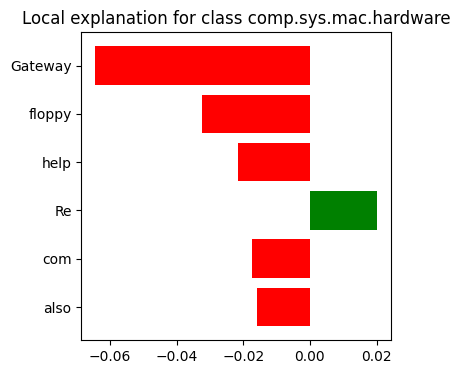

In [ ]:
# Visualize this as a figure
fig = exp.as_pyplot_figure()

In [ ]:
# This are the main internal components:
# LIME actually generates an approximate sparse linear model
# around the given instance.
# This linear model has an intercept:
print(f'Intercept: {exp.intercept}\n')
# A sparse set of linear coefficients, here associated to internal word indexes:
print(f'Local explanation raw: {exp.local_exp}\n')
for w, val in exp.as_list():
    print(f'{w}: {val}')
# As well as the performance of this linear model in approximating the real
# model's outputs:
print(f'\nScore: {exp.score}')

Intercept: {1: 0.4976190603237748}

Local explanation raw: {1: [(39, -0.06435512004646776), (11, -0.03225343169592571), (112, -0.021612019741917395), (8, 0.020205171465386175), (31, -0.017277312414342563), (68, -0.01573579075043598)]}

Gateway: -0.06435512004646776
floppy: -0.03225343169592571
help: -0.021612019741917395
Re: 0.020205171465386175
com: -0.017277312414342563
also: -0.01573579075043598

Score: {1: 0.6550239190361877}


Now let's check that the above explanation gives actionable knowledge about the model prediction. One way to use the explanation is to generate **counterfactual examples** and examine if the associated outputs are in line with our predictions. Here, try to generate a counterfactual text input without the top two words contributing to the "PC" decision and see if the predictions evolve in the good direction.

In [ ]:
## TODO Counterfactual reasoning from explanation
print('Original prediction:', rf.predict_proba(test_vectors[idx])[0])
counter = test_vectors[idx].copy()
counter[0, vectorizer.vocabulary_['Gateway']] = 0
counter[0, vectorizer.vocabulary_['floppy']] = 0
print('Prediction removing some features:', rf.predict_proba(counter)[0])
print('Difference:', rf.predict_proba(counter)[0, 0] - rf.predict_proba(test_vectors[idx])[0, 0])

Original prediction: [0.632 0.368]
Prediction removing some features: [0.546 0.454]
Difference: -0.08599999999999997


# Part 2: implementing a mini-LIME

The goal of this part is to reimplement the LIME algorithm from scratch, with the particular focus on Tf-Idf vectorized text instances. The algorithm is split in two parts:

1) Generate a "local dataset" of perturbed data lying in the neighborhood of the given instance, and sample model predictions on this local dataset

2) Fit a locally linear sparse model to the local dataset and its associated predictions

In [ ]:
# Write a function generating the perturbed dataset around an instance
# Given the sparsity of text wrt the actual vocabulary, we will only perturb
# words that are in the given instance
# We suggest eg sampling a number of words to perturb and then the actual words
# to perturb

GEOM_P = 0.75

def generate_perturbed_xy(x0, pred_fun, n_samples=5000):
    D = x0.shape[0]
    nonzero_idxes = np.nonzero(x0)[0]
    data = np.tile(x0, (n_samples + 1, 1))

    # Sampling number of words to silence for each sample
    p = 1. / len(nonzero_idxes)
    num_words = scipy.stats.geom.rvs(GEOM_P, size=n_samples).clip(1, len(nonzero_idxes))

    # Perturb samples accordingly
    for i in range(n_samples):
        choices = np.random.choice(len(nonzero_idxes), num_words[i],
                                  replace=False)
        choices = choices.astype(int)
        choices = nonzero_idxes[choices.tolist()]
        data[i+1, choices] = 0.

    # Generate predictions for all samples
    preds = pred_fun(data)

    return data, preds


In [ ]:
idx = 0
data, preds = generate_perturbed_xy(test_vectors[idx].toarray().ravel(), rf.predict_proba)
print(data.shape)
print(preds.shape)

(5001, 21486)
(5001, 2)


In [ ]:
# Fit a local linear sparse model (for example with Lasso)
# To avoid issues with sparsity, you can keep only the non-zero columns
# of the perturbed data

def make_reduced_data(data):
    idxes = np.nonzero(data.sum(axis=0))[0]
    new_data = data[:, idxes]
    return new_data, idxes, {idxes[i]: i for i in range(len(idxes))}

def fit_llsm(data, preds):
    model = Lasso(alpha=1e-5, fit_intercept=True)
    model.fit(data, preds[:, 1])
    score = model.score(data, preds[:, 1])
    return model.coef_, model.intercept_, score

# Solution note: Lasso is inconvenient because of the need to choose the value
# of alpha by hand, and under-exploits one of the best capacities of the Lasso
# algorithm: the possibility to build a Lars path equivalent to a continuous
# scaling of alpha, and to retain a fixed number of non-zero features.

In [ ]:
# Test your LIME procedure
red_data, idxes, back_idxes = make_reduced_data(data)
weights, intercept, score = fit_llsm(red_data, preds)
print(score)

# Visualize the most important words retained by your explainer
n_features = 10
args = np.argsort(np.abs(weights))[::-1][:n_features]
for i in range(n_features):
    print(f'{inverse_vocab[idxes[args[i]]]}: {weights[args[i]]}')

0.6500823833599383
card: -0.5622264379522555
FPU: 0.1995035916042568
and: 0.13445264460447745
the: 0.1265846999876997
new: 0.10315649881761385
about: 0.09743500763266602
handle: -0.09641066136349581
version: -0.05681095349282408
Why: 0.04030081416550602
netters: -0.03739532079843397


# Part 3: aggregate results over a lot of examples

In this part, we will see how to exploit LIME results to get a more global understanding of our classifier by combining explanations on many instances.

In [ ]:
# Recover a dictionary combining words extracted by the explainer and
# a list of the values found by explanations for these words
word_values = dict()
scores = []

for idx, text in enumerate(newsgroups_test.data[:50]):
    exp = explainer.explain_instance(newsgroups_test.data[idx], c.predict_proba, num_features=6)
    scores.append(exp.score)
    words = exp.as_list()
    for w, val in words:
        if w not in word_values:
            word_values[w] = []
        word_values[w].append(val)


In [ ]:
# Recover the most important words (ie those coming back most often in
# explanations)

word_lengths = {w: len(word_values[w]) for w in word_values}
top_words = sorted(word_lengths.items(), key=lambda x: x[1], reverse=True)[:10]
for w in top_words:
    print(w)
top_words, _ = zip(*top_words)

('edu', 22)
('Apple', 12)
('card', 11)
('Re', 8)
('Mac', 7)
('the', 6)
('Posting', 6)
('help', 6)
('com', 6)
('From', 6)


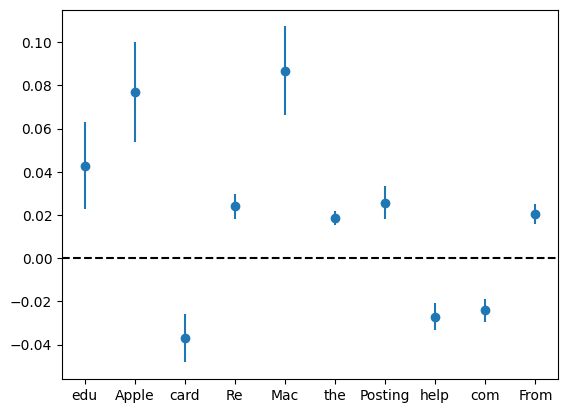

In [ ]:
# Visualize these results (eg with an errorbar plot)
means = [np.mean(word_values[w]) for w in top_words]
stds = [np.std(word_values[w]) for w in top_words]

plt.errorbar(np.arange(len(top_words)), means, stds, ls='', marker='o')
plt.xticks(np.arange(len(top_words)), top_words)
plt.axhline(0, ls='--', c='k')

Due to randomness in the LIME algorithm, the exact same results will not be recovered. What can you say about your results?

I had that "Apple" and "Mac" are strong explainers for the apple category (which makes sense), while "edu" pushed strongly for the apple category and "com" for the Microsoft one (is it a bug or feature? might be an interesting characteristic of the data). What about "help" pointing for the Microsoft community (sorry MS, such is the data!)

Other characteristics are more questionable, like the presence of "Re" and "From" as strong drivers in the apple direction.

# Part 4: LIME for images

In this final part, the goal is to play with LIME for image models, and explore the potential and limitations of this explainability method.

Full reference will be in the original paper, but briefly LIME in this domain works by perturbing "super pixels" and then predicting which super pixels have the strongest impact in the locally linear sparse model.

In [ ]:
import torch
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from skimage.segmentation import mark_boundaries

In [ ]:
# Download some data (imagenet classes and some images)
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
!wget https://adrian-valente.github.io/assets/lime_images.zip
!unzip lime_images.zip

--2023-11-18 20:22:45--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt.4’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2023-11-18 20:22:45 (40.6 MB/s) - ‘imagenet_classes.txt.4’ saved [10472/10472]

--2023-11-18 20:22:45--  https://adrian-valente.github.io/assets/lime_images.zip
Resolving adrian-valente.github.io (adrian-valente.github.io)... 185.199.108.153, 185.199.110.153, 185.199.111.153, ...
Connecting to adrian-valente.github.io (adrian-valente.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 714261 (698K) [application/zip]
Saving to

In [ ]:
# Load the imagenet class labels
with open("imagenet_classes.txt", "r") as f:
    imagenet_classes = [s.strip() for s in f.readlines()]

In [ ]:
# Load the pretrained inception model
inception = models.inception_v3(pretrained=True)
_ = inception.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:01<00:00, 72.6MB/s]


In [ ]:
inception = inception.to(device='cuda')

In [ ]:
# Here is the process to load an image, preprocess it and obtain prediction
# from the model
image = Image.open('lime_images/dog_guitar.jpg')
preprocess = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)
input_batch = input_batch.to(device='cuda')

preds = inception.forward(input_batch)
probs = F.softmax(preds[0], dim=0).cpu()

top5_prob, top5_catid = torch.topk(probs, 5)
for i in range(top5_prob.size(0)):
    print(imagenet_classes[top5_catid[i]], top5_prob[i].item())

acoustic guitar 0.828158438205719
electric guitar 0.021617084741592407
golden retriever 0.012029975652694702
pick 0.011863522231578827
banjo 0.009087256155908108


In [ ]:
# Here is the process to obtain an explanation

pil_preprocess = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224)
])

preprocess_pt = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def batch_predict(images):
    batch = torch.stack(tuple(preprocess_pt(i) for i in images), dim=0)
    batch = batch.to(device='cuda')
    logits = inception(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

explainer = LimeImageExplainer()
exp = explainer.explain_instance(
    np.array(pil_preprocess(image)),
    batch_predict,
    top_labels=5,
)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
# The explanation automatically chooses the top labels for the instance being run
[imagenet_classes[i] for i in exp.top_labels]

['golden retriever',
 'acoustic guitar',
 'Labrador retriever',
 'Brittany spaniel',
 'Saluki']

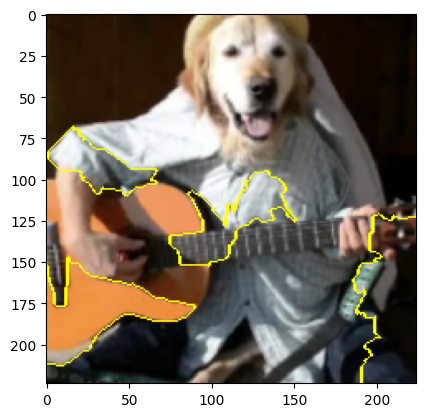

In [ ]:
# We can play with the following function to visualize the explanation,
# for the different labels. Does it make sense?
idx_label = 1
temp, mask = exp.get_image_and_mask(
    exp.top_labels[idx_label],
    positive_only=True,
    num_features=5,
    hide_rest=False
)
img_boundry = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry)



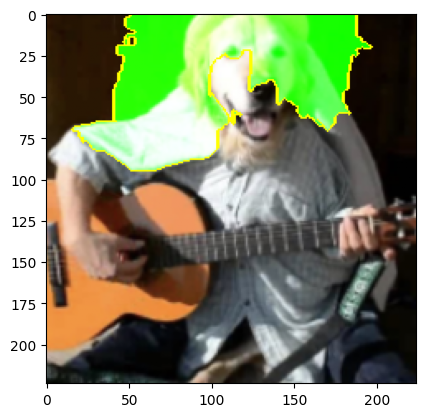

In [ ]:
idx_label = 0
temp, mask = exp.get_image_and_mask(
    exp.top_labels[idx_label],
    positive_only=False,
    num_features=5,
    hide_rest=False
)
img_boundry = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry)



Now reproduce this process with the husky image, and the cat1 image. Do you obtain results that make sense?

# Bonus: the texture bias

In a paper from 2019, Geirhos et al. uncovered the "texture bias" of image classification models that has been quite reliably reproducible. As an example, load the image cat2.jpg, and observe the predictions of the model and its explanations. Does the model lead to relevant explanation of the model's behavior?

What can you say about limitations of LIME from this? And how useful do you think it might be to understand model failure models like [adversarial examples](https://openai.com/research/attacking-machine-learning-with-adversarial-examples)

In [ ]:
image = Image.open('cat2.jpg')
preprocess = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)
input_batch = input_batch.to(device='cuda')

In [ ]:
preds = inception.forward(input_batch)
probs = F.softmax(preds[0], dim=0).cpu()
top5_prob, top5_catid = torch.topk(probs, 5)
for i in range(top5_prob.size(0)):
    print(imagenet_classes[top5_catid[i]], top5_prob[i].item())


African elephant 0.6712186336517334
Indian elephant 0.14347919821739197
tusker 0.13244055211544037
nail 0.005517927464097738
buckle 0.002607523463666439


In [ ]:
  explainer = LimeImageExplainer()
  exp = explainer.explain_instance(
      np.array(pil_preprocess(image)),
      batch_predict,
      top_labels=5,
  )

  0%|          | 0/1000 [00:00<?, ?it/s]

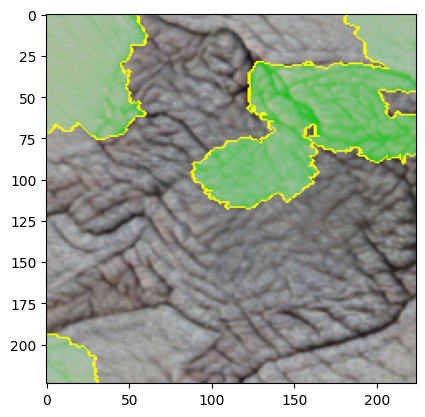

In [ ]:
idx_label = 0
temp, mask = exp.get_image_and_mask(
    exp.top_labels[idx_label],
    positive_only=False,
    num_features=5,
    hide_rest=False
)
img_boundry = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry)

